In [ ]:
pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('HandsOnPertemuan9').getOrCreate()

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



In [ ]:
spark.sql('''
SELECT Gender, Age, SUM(Salary) AS TotalSalary
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

#rata rata gaji
spark.sql('''
SELECT DeptId, AVG(Salary) AS AvgSalary
FROM employees
GROUP BY DeptId
''').show()

#gaji diatas rata rata sesuai gender
spark.sql('''
WITH AvgSalaryByGender AS (
    SELECT Gender, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY Gender
)
SELECT e.Name, e.Gender, e.Salary, a.AvgSalary
FROM employees e
JOIN AvgSalaryByGender a
  ON e.Gender = a.Gender
WHERE e.Salary > a.AvgSalary
''').show()

#rangking karyawan
spark.sql('''
SELECT Name, DeptId, Salary,
       RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS Rank
FROM employees
''').show()



+------+---+-----------+
|Gender|Age|TotalSalary|
+------+---+-----------+
|     M| 23|       2700|
|     F| 28|       4100|
|     M| 34|       3000|
+------+---+-----------+

+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+

+-----+------+------+---------+
| Name|Gender|Salary|AvgSalary|
+-----+------+------+---------+
|James|     M|  3000|   2850.0|
+-----+------+------+---------+

+-----+------+------+----+
| Name|DeptId|Salary|Rank|
+-----+------+------+----+
|James|     1|  3000|   1|
|  Lee|     1|  2700|   2|
| Anna|     2|  4100|   1|
+-----+------+------+----+



In [ ]:
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER
(PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()

+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

#rata rata gaji karyawan
spark.sql('''
SELECT e.Name, d.DeptName, e.salary,
AVG(a.salary) OVER (PARTITION BY e.DeptId) AS AvgSalaryPerDept,
RANK() OVER (PARTITION BY e.DeptId ORDER BY e.salary DESC) AS SalaryRank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN employees a ON e.DeptId = a.DeptId
''').show()


#tren gaji
spark.sql('''
SELECT e.Name, d.DeptName, e.Age, e.Salary,
ROW_NUMBER() OVER (PARTITION BY e.DeptId ORDER BY e.Age ASC) AS AgeRank,
AVG(e.Salary) OVER (
PARTITION BY e.DeptId
ORDER BY e.Age ASC
ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
) AS CumulativeAvgSalary
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
''').show()

+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+

+-----+---------+------+----------------+----------+
| Name| DeptName|salary|AvgSalaryPerDept|SalaryRank|
+-----+---------+------+----------------+----------+
|James|       HR|  3000|          2850.0|         1|
|James|       HR|  3000|          2850.0|         1|
|  Lee|       HR|  2700|          2850.0|         3|
|  Lee|       HR|  2700|          2850.0|         3|
| Anna|Marketing|  4100|          4100.0|         1|
+-----+---------+------+----------------+----------+

+-----+---------+---+------+-------+-------------------+
| Name| DeptName|Age|Salary|AgeRank|CumulativeAvgSalary|
+-----+---------+---+------+-------+-------------------+
|  Lee|       HR| 23|  2700|      1|             2700.0|
|James|       HR| 34|  3000|      2|             2850.0

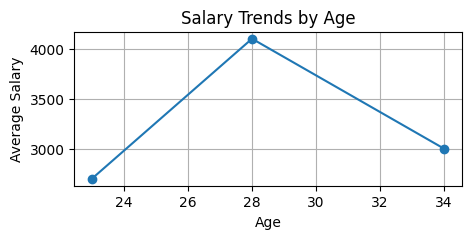

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(5, 2))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

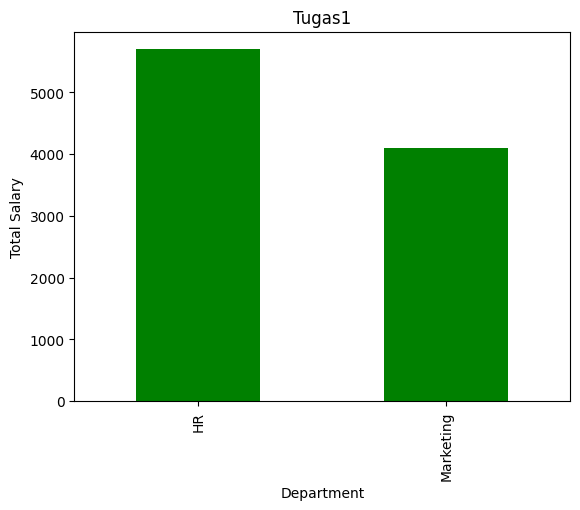

In [ ]:
#Tugas 1: Gunakan Spark SQL untuk mencari total gaji dan jumlah
#karyawan per departemen. Buat visualisasi perbandingan antar departemen.
import matplotlib.pyplot as plt
import pandas as pd

tugas1 = spark.sql('''
SELECT SUM(e.Salary) AS TotalSalary, d.DeptName, COUNT(e.Name) AS EmployeeCount
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY DeptName
''').toPandas()

tugas1.plot(kind='bar', x='DeptName', y='TotalSalary', legend=False, color='green')
plt.title('Tugas1')
plt.xlabel('Department')
plt.ylabel('Total Salary')
plt.show()

        Name  Age  Salary
0      James   34    5000
1       Anna   28    4100
2     Sunday   28    4200
3  Jing Yuan   23    3900


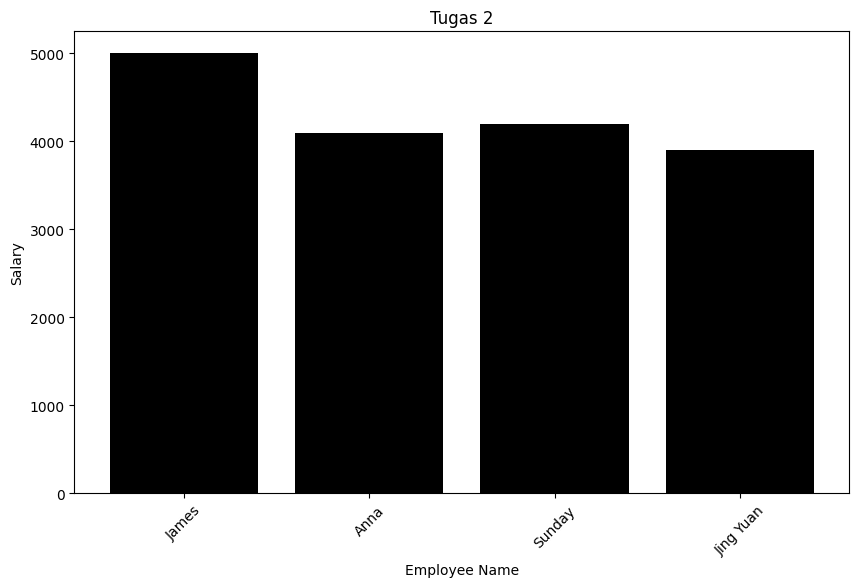

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName('HandsOnPertemuan9').getOrCreate()

# Define data and create DataFrame
data = [
    ('James', 34, 'M', 5000, 1),  # Increased salary for variety in data
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('Baldie', 28, 'M', 3500, 3),
    ('Danil', 34, 'm', 2200, 2),
    ('Sunday', 28, 'F', 4200, 2),
    ('Jing Yuan', 23, 'M', 3900, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView("employees")

# SQL query to find employees with salary above the average in each age group
result_df = spark.sql('''
    WITH AvgSalary AS (
        SELECT Age, AVG(Salary) AS AvgSal
        FROM employees
        GROUP BY Age
    )
    SELECT e.Name, e.Age, e.Salary
    FROM employees e
    JOIN AvgSalary a ON e.Age = a.Age
    WHERE e.Salary > a.AvgSal
''').toPandas()  # Convert to Pandas DataFrame

# Check if the result is empty
if result_df.empty:
    print("No employees have a salary above the average in their age group.")
else:
    print(result_df)

    # Visualization: Bar Chart
    plt.figure(figsize=(10, 6))
    plt.bar(result_df['Name'], result_df['Salary'], color='black')
    plt.xlabel('Employee Name')
    plt.ylabel('Salary')
    plt.title('Tugas 2')
    plt.xticks(rotation=45)
    plt.show()

+---------+-----------+-----------------+-------------+
| DeptName|TotalSalary|        AvgSalary|EmployeeCount|
+---------+-----------+-----------------+-------------+
|       HR|     106571|4844.136363636364|           22|
|Marketing|     138809|5141.074074074074|           27|
+---------+-----------+-----------------+-------------+



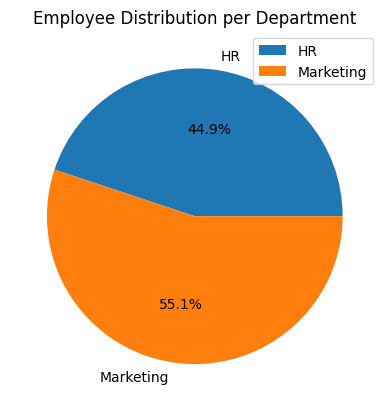

In [ ]:
# Buat dataset yang lebih besar (misalnya, 100+ baris) dan lakukan analisis
#mendalam menggunakan SQL functions seperti SUM(), AVG(), COUNT(),
#serta JOIN antar tabel. dibuat visualsisai

import random
data = [
    (f'Employee{i}', random.randint(20, 60), random.choice(['M', 'F']),
     random.randint(2000, 8000), random.randint(1, 5))
    for i in range(1, 101)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
large_df = spark.createDataFrame(data, columns)
large_df.createOrReplaceTempView('large_employees')

# Analisis total dan rata-rata gaji per departemen
analysis_result = spark.sql('''
SELECT d.DeptName,
SUM(e.Salary) AS TotalSalary,
AVG(e.Salary) AS AvgSalary,
COUNT(e.Name) AS EmployeeCount
FROM large_employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
''')
analysis_result.show()

# Convert to Pandas DataFrame
df3 = analysis_result.toPandas()

# Visualisasi dengan Pie Chart
df3.plot(kind='pie', y='EmployeeCount', labels=df3['DeptName'], autopct='%1.1f%%')
plt.title('Employee Distribution per Department')
plt.ylabel('')
plt.show()
